In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install brewer2mpl

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pandas as pd
import numpy as np
import sys
import random
import brewer2mpl
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import optimizers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
from keras.losses import categorical_crossentropy

Using TensorFlow backend.


In [0]:
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

In [0]:
def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    print ('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

In [0]:
def load_data(sample_split=0.3, usage='Training',classes=['Angry','Happy'], 
              filepath="/content/gdrive/My Drive/EXP_Folder/Dataset/fer2013.csv"):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

In [0]:
def save_data(X_train, y_train, fname='', folder='/content/gdrive/My Drive/EXP_Folder/data/'):
    """
    The function stores loaded data into numpy form for further processing
    """
    np.save(folder +  'X' + fname, X_train)
    np.save(folder +  'y' + fname, y_train)
    
if __name__ == "__main__":
    # makes the numpy arrays ready to use:
    print("Making moves...")
    emo = ["Angry", "Fear", "Happy","Sad", "Surprise", "Neutral"]
    X_train, y_train = load_data(sample_split=1.0,classes=emo, usage= 'Training')
    print("Saving...")
    save_data(X_train, y_train, fname="_training")
    print("x training: ", X_train.shape)
    print("y training: ", y_train.shape)

    X_val, y_val = load_data(sample_split=1.0,classes=emo, usage= 'PublicTest')
    print("Saving...")
    save_data(X_val, y_val, fname="_public")
    print("x public: ", X_val.shape)
    print("y public: ", y_val.shape)

    X_test, y_test = load_data(sample_split=1.0,classes=emo, usage='PrivateTest')
    print("Saving...")
    save_data(X_test, y_test, fname="_private")
    print("x private: ", X_test.shape)
    print("y private: ", y_test.shape)
    print("Done!")

Making moves...
Disgust classified as Angry


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Saving...
x training:  (28709, 48, 48, 1)
y training:  (28709, 6)
Disgust classified as Angry
Saving...
x public:  (3589, 48, 48, 1)
y public:  (3589, 6)
Disgust classified as Angry
Saving...
x private:  (3589, 48, 48, 1)
y private:  (3589, 6)
Done!


In [0]:
# Final Model Architecture:
epoch = 50
batch_size = 64
learning_rate = 0.001
num_features = 64
num_labels = 6
width, height = 48, 48


modelN = Sequential()
#Phase 1
modelN.add(layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), 
                         data_format='channels_last', kernel_regularizer=l2(0.01)))
modelN.add(layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelN.add(layers.BatchNormalization())
modelN.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelN.add(layers.Dropout(0.5))
#Phase 2
modelN.add(layers.Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelN.add(layers.BatchNormalization())
modelN.add(layers.Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelN.add(layers.BatchNormalization())
modelN.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelN.add(layers.Dropout(0.5))
#Phase 3
modelN.add(layers.Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelN.add(layers.BatchNormalization())
modelN.add(layers.Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelN.add(layers.BatchNormalization())
modelN.add(layers.MaxPooling2D(pool_size=(2, 2), strides= (2, 2)))
modelN.add(layers.Dropout(0.5))
#Phase 4
modelN.add(layers.Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelN.add(layers.BatchNormalization())
modelN.add(layers.Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
modelN.add(layers.BatchNormalization())
modelN.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelN.add(layers.Dropout(0.5))

modelN.add(layers.Flatten())
#Phase 5
modelN.add(layers.Dense(2*2*2*num_features, activation='relu'))
modelN.add(layers.Dropout(0.4))
#Phase 6
modelN.add(layers.Dense(2*2*num_features, activation='relu'))
modelN.add(layers.Dropout(0.4))
#Phase 7
modelN.add(layers.Dense(2*num_features, activation='relu'))
modelN.add(layers.Dropout(0.5))

modelN.add(layers.Dense(num_labels, activation='softmax'))

modelN.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])
print(modelN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_16 (Batc (None, 23, 23, 128)       512       
__________

In [0]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/EXP_Folder/checkpoint/weights.h5', 
                               monitor='val_loss', verbose=1, save_best_only=True)
print ('Training....')
modelF = modelN.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,
          validation_data=(X_val, y_val), shuffle=True, verbose=1, callbacks=[lr_reducer, checkpointer])

Training....
Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 60s 2ms/step - loss: 1.9265 - acc: 0.2145 - val_loss: 1.7755 - val_acc: 0.2494

Epoch 00001: val_loss improved from inf to 1.77547, saving model to /content/gdrive/My Drive/EXP_Folder/checkpoint/weights.hd5
Epoch 2/50
28709/28709 [==============================] - 56s 2ms/step - loss: 1.7750 - acc: 0.2441 - val_loss: 1.7554 - val_acc: 0.2494

Epoch 00002: val_loss improved from 1.77547 to 1.75542, saving model to /content/gdrive/My Drive/EXP_Folder/checkpoint/weights.hd5
Epoch 3/50
28709/28709 [==============================] - 56s 2ms/step - loss: 1.7579 - acc: 0.2527 - val_loss: 1.7428 - val_acc: 0.2494

Epoch 00003: val_loss improved from 1.75542 to 1.74279, saving model to /content/gdrive/My Drive/EXP_Folder/checkpoint/weights.hd5
Epoch 4/50
28709/28709 [==============================] - 56s 2ms/step - loss: 1.7096 - acc: 0.2749 - val_loss: 2.0688 - val_acc: 0.251

In [0]:
model_json = modelN.to_json()
with open("modelN.json","w") as json_file:
     json_file.write(model_json)

from keras.models import model_from_json
model_json = modelN.to_json()
with open("/content/gdrive/My Drive/EXP_Folder/ModelN/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelN.save_weights("/content/gdrive/My Drive/EXP_Folder/ModelN/model.h5")
print("Saved model to disk")

Saved model to disk


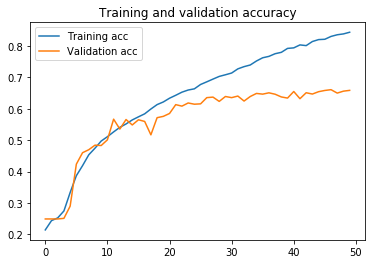

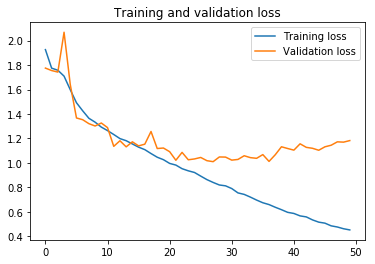

In [0]:
modelN.save('/content/gdrive/My Drive/EXP_Folder/ModelN/backupmodel.hdf5')

## Plot to train/validation accuracy/cost
import matplotlib.pyplot as plt

acc = modelF.history['acc']
val_acc = modelF.history['val_acc']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
X_fname = '/content/gdrive/My Drive/EXP_Folder/data/X_public.npy'
y_fname = '/content/gdrive/My Drive/EXP_Folder/data/y_public.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Public test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (labels)
print (counts)
# evaluate model on private test set
score = modelN.evaluate(X, y, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

Public test set
['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
[523 496 895 653 415 607]
model acc: 65.87%


In [0]:
X_fname = '/content/gdrive/My Drive/EXP_Folder/data/X_private.npy'
y_fname = '/content/gdrive/My Drive/EXP_Folder/data/y_private.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (labels)
print (counts)
# evaluate model on private test set
score = modelN.evaluate(X, y, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

Private test set
['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
[546 528 879 594 416 626]
model acc: 67.65%


In [0]:
# prediction and true labels
y_prob = modelN.predict(X, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]

In [0]:
def plot_subjects(start, end, y_pred, y_true, title=False):
    """
    The function is used to plot the picture subjects
    """
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#FF0000',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], color='#1C05F4',fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [0]:
def plot_probs(start,end, y_prob):
    """
    The function is used to plot the probability in histogram for six labels 
    """
    fig = plt.figure(figsize=(12,12))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
        ax.bar(np.arange(0,6), y_prob[i], color=set3,alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [0]:
def plot_subjects_with_probs(start, end, y_prob):
    """
    This plotting function is used to plot the probability together with its picture
    """
    iter = int((end - start)/6)
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

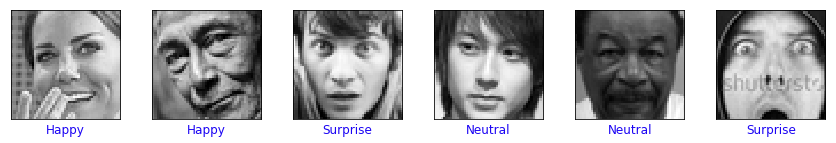

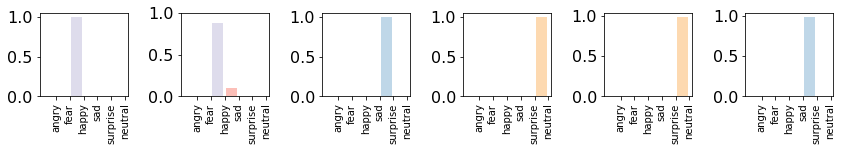

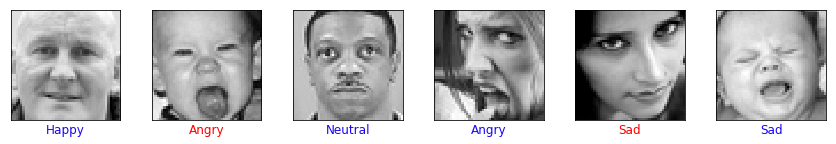

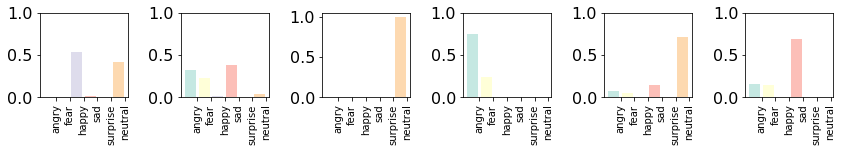

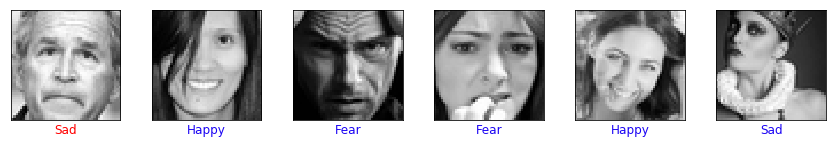

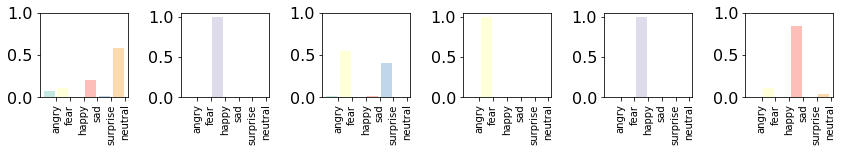

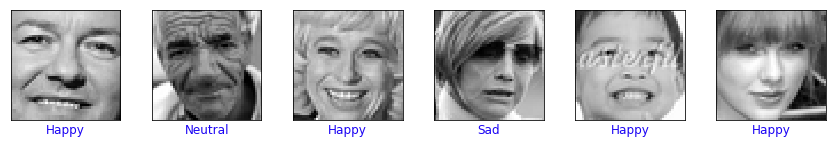

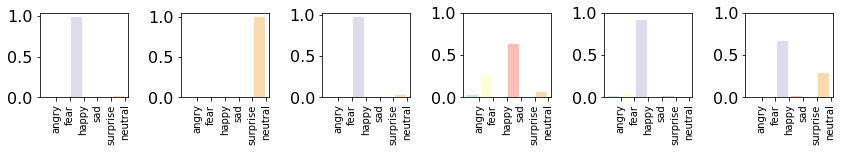

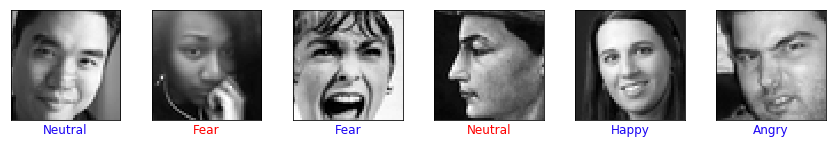

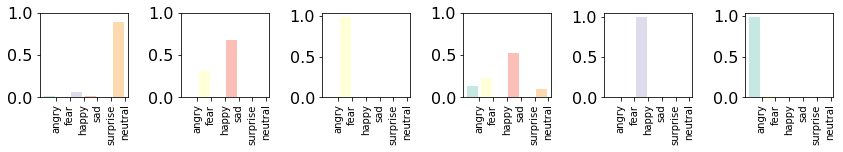

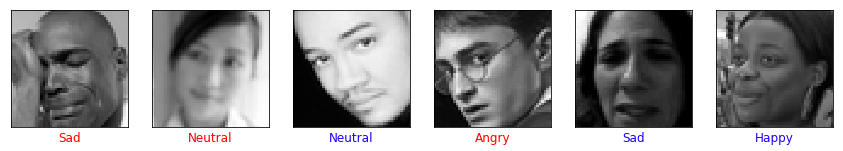

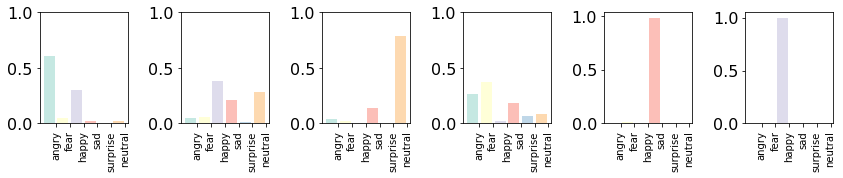

In [0]:
plot_subjects_with_probs(0, 36, y_prob)

In [0]:
y_fname1 = '/content/gdrive/My Drive/EXP_Folder/data/y_training.npy'
y_fname2 = '/content/gdrive/My Drive/EXP_Folder/data/y_public.npy'
y_fname3 = '/content/gdrive/My Drive/EXP_Folder/data/y_private.npy'
y_train = np.load(y_fname1) # train
y_public = np.load(y_fname2) # public
y_private = np.load(y_fname3) # private
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_public]
y_private_labels = [np.argmax(lst) for lst in y_private]

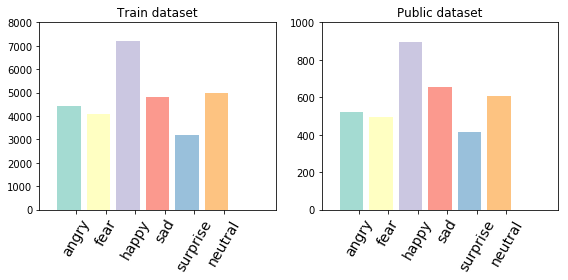

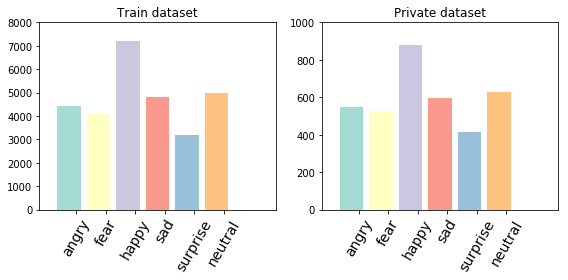

In [0]:
import brewer2mpl
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    """
    The function is used to plot the distribution of the labels of provided dataset 
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,7), np.bincount(y1), color=colorset, alpha=0.8)
    ax1.set_xticks(np.arange(1.25,7.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,7), np.bincount(y2), color=colorset, alpha=0.8)
    ax2.set_xticks(np.arange(1.25,7.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_train_labels, y_public_labels, \
                  ['Train dataset', 'Public dataset'], \
                  ylims =[8000,1000])
plot_distribution(y_train_labels, y_private_labels, \
                  ['Train dataset', 'Private dataset'], \
                  ylims =[8000,1000])

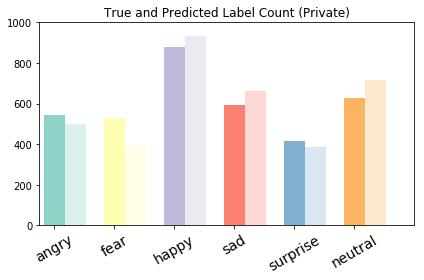

In [0]:
def plot_distribution2(y_true, y_pred):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    ind = np.arange(1.5,7,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 7.5])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()
    
plot_distribution2(y_true, y_pred)

In [0]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

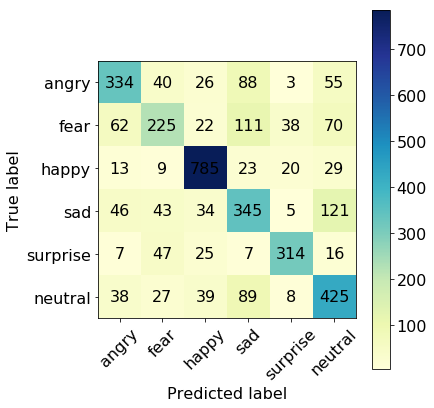

In [0]:
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()

In [0]:
#Classification Matrix

def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,6)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,6)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [0]:
# private test set
for emotion in labels:
    print (emotion.upper())
    print ('   acc = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print ('  prec = {}'.format(class_precision(y_true, y_pred, emotion)))
    print ('recall = {}'.format(class_recall(y_true, y_pred, emotion)))

ANGRY
   acc = 0.8946781833379771
  prec = 0.668
recall = 0.6117216117216118

FEAR
   acc = 0.8693229311786013
  prec = 0.5754475703324808
recall = 0.42613636363636365

HAPPY
   acc = 0.9331290052939537
  prec = 0.8431793770139635
recall = 0.8930602957906713

SAD
   acc = 0.8420172750069658
  prec = 0.5203619909502263
recall = 0.5808080808080808

SURPRISE
   acc = 0.9509612705488995
  prec = 0.8092783505154639
recall = 0.7548076923076923

NEUTRAL
   acc = 0.8629144608526051
  prec = 0.5935754189944135
recall = 0.6789137380191693



In [0]:
from sklearn.metrics import classification_report
print (classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

       angry       0.67      0.61      0.64       546
        fear       0.58      0.43      0.49       528
       happy       0.84      0.89      0.87       879
         sad       0.52      0.58      0.55       594
    surprise       0.81      0.75      0.78       416
     neutral       0.59      0.68      0.63       626

    accuracy                           0.68      3589
   macro avg       0.67      0.66      0.66      3589
weighted avg       0.68      0.68      0.67      3589

